# 1 Processing & Analytical


1. Sessionize the web log by IP. Sessionize = aggregrate all page hits by visitor/IP during a fixed time window. https://en.wikipedia.org/wiki/Session_(web_analytics)

2. Determine the average session time

3. Determine unique URL visits per session. To clarify, count a hit to a unique URL only once per session.

4. Find the most engaged users, ie the IPs with the longest session times

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
import sys

In [2]:
sc.stop()

In [3]:
## start a session
conf = SparkConf().setMaster("local").setAppName("WebLog")
sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

In [4]:
## read in file
raw_file = sc.textFile("2015_07_22_mktplace_shop_web_log_sample.log")
## processing raw file to get information needed
web_log = raw_file.map(lambda line: line.split(" "))

#Map RDD to a DF for better performance and convenience
def process(line):
    return [line[0],line[2].split(":")[0],line[12]]

info_rdd = web_log.map(lambda line: process(line))

## create data frame keep information will be used only
df=sqlContext.createDataFrame(info_rdd,['TimeStamp','IP','URL'])

## order by IP and time stamp for better observation
df = df.orderBy(["IP", "TimeStamp"])
df.show()

+--------------------+------------+--------------------+
|           TimeStamp|          IP|                 URL|
+--------------------+------------+--------------------+
|2015-07-22T10:45:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:45:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:46:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:46:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101.79|https://paytm.com...|
|2015-07-22T10:47:...|1.186.101

## 1.1 Sessionize web log
After reading the data, we get the observation that the web log covers the following information on which IP requested visiting what URL at what time.
    
Follow the instruction, we can sessionize using time instead of navigation. After investigate the data, we found that one IP will visit multiple URL at multiple time, sometimes there's huge time gap between two visit, which should not be consided as one session. 

In this case, for one IP if there's no more visit after 15 minutes, the user could be considered as inactive. The next visit should be considered as a start of another session.

In [5]:
## make sure the data have no duplications
df.count(),df.dropDuplicates().count()

(1158500, 1158500)

In [6]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [7]:
## change to time data type
df = df.withColumn('TimeStamp', df['TimeStamp'].cast(TimestampType()))

## move the time column by 1 lag to find the last visit for most of the rows
w = Window().partitionBy('IP').orderBy('TimeStamp')
df = df.withColumn("LastTime", lag("TimeStamp", 1).over(w))

## calculate the different between this time stamp with last visit
timeDiff = (unix_timestamp(df.TimeStamp)-unix_timestamp(df.LastTime))
df = df.withColumn("TimeDiff", timeDiff)

## rank within each IP to find the first visit for each IP, and put the time difference to zero to analysis
df =  df.withColumn("rank", dense_rank().over(Window.partitionBy("IP").orderBy("TimeStamp")))
#df = df.withColumn('TimeDiff',when((df.rank > 1), df.TimeDiff).otherwise(0))

df = df.orderBy(['IP','TimeStamp'])
#df.show(50)

(array([ 6891.,  2995.,  1273.,   550.,   394.,   865.,   727.,   713.,
          624.,   557.,   573.,   762.,   640.,   520.,   513.,   409.,
          583.,   614.,   566.,   476.]),
 array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
         650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100]),
 <a list of 20 Patch objects>)

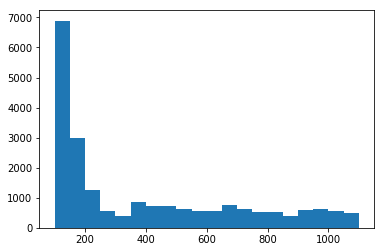

In [8]:
## Analysis the time difference distribution, breaking by 15 minutes looks okay at it's already in long tail
import matplotlib.pyplot as plt
%matplotlib inline

bins, counts = df.filter((col('TimeDiff') >= 100 ) & (col('TimeDiff') <= 1100 )).select(col('TimeDiff')).rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [9]:
## breaking by 15 minutes looks okay, change the first row of reach IP to large value over 900 to break to session 
df = df.withColumn('TimeDiff',when((df.rank > 1), df.TimeDiff).otherwise(999))

## each time when time differnece is larger than 15 minutes, give a different session ID
df = df.withColumn('SessionID',when((df.TimeDiff > 15*60), monotonically_increasing_id()).otherwise(None))

## fill the session ID by forward value to assign each row with session ID
df = df.withColumn("SessionID", last('SessionID', True).\
                   over(Window.partitionBy().orderBy().rowsBetween(-sys.maxsize, 0)))

df = df.orderBy(['IP','TimeStamp'])
#df.show(50)

## 1.2 Determine the average session time

In [10]:
## aggregate first/last visit by each session, and take the time difference
Sess_time_df = df.groupBy(['IP',"SessionID"]).agg(max("TimeStamp").alias("LastVisit"),\
                                               min("TimeStamp").alias("FirstVisit"))

timeDiff = (unix_timestamp(Sess_time_df.LastVisit)-unix_timestamp(Sess_time_df.FirstVisit))
Sess_time_df = Sess_time_df.withColumn("SessionTime", timeDiff)
#Sess_time_df.show()

In [11]:
## calculate the average session time 
Sess_time_df.select(avg('SessionTime')).show()

+------------------+
|  avg(SessionTime)|
+------------------+
|100.75318265890739|
+------------------+



The Average seession time is around 100 seconds, which 1 minutes and 20 seconds.

## 1.3 Determine unique URL visits per session

In [12]:
## Aggregate the distinct URL by session
URL_df = df.groupBy("SessionID").agg(countDistinct("URL").alias("Unique_URL_cnt"))
#URL_df.show()

In [13]:
## calculate the average unique URL visit  
URL_df.select(avg('Unique_URL_cnt')).show()

+-------------------+
|avg(Unique_URL_cnt)|
+-------------------+
|  8.298515811792305|
+-------------------+



## 1.4 Find the most engaged users, ie the IPs with the longest session times

In [14]:
URL_df.count(),Sess_time_df.count()

(110835, 110835)

In [15]:
## get table with both session time, and unique url with their IP
Session_URL_df = URL_df.join(Sess_time_df, 'SessionID') # Could also use 'left_outer', the counts are the same
#Session_URL_df.show()

In [16]:
#the most engaged users with the longest session times
Session_URL_df.sort(col("SessionTime").desc()).limit(10).show()

+-------------+--------------+--------------+--------------------+--------------------+-----------+
|    SessionID|Unique_URL_cnt|            IP|           LastVisit|          FirstVisit|SessionTime|
+-------------+--------------+--------------+--------------------+--------------------+-----------+
| 180388626435|             1| 106.186.23.95|2015-07-22 04:04:...|2015-07-22 03:30:...|       2069|
|1468878815234|          9532|  52.74.219.71|2015-07-22 04:04:...|2015-07-22 03:30:...|       2069|
| 884763262991|             6|  125.19.44.66|2015-07-22 04:04:...|2015-07-22 03:30:...|       2068|
| 884763263082|             6|  125.20.39.66|2015-07-22 04:04:...|2015-07-22 03:30:...|       2068|
|1065151889642|             5|180.211.69.209|2015-07-22 04:04:...|2015-07-22 03:30:...|       2067|
|1176821039133|             5|  192.8.190.10|2015-07-22 04:04:...|2015-07-22 03:30:...|       2067|
|1597727834117|             2| 54.251.151.39|2015-07-22 04:04:...|2015-07-22 03:30:...|       2067|


In [17]:
#the most engaged users with the most unique URL visit
Session_URL_df.sort(col("Unique_URL_cnt").desc()).limit(10).show()

+-------------+--------------+---------------+--------------------+--------------------+-----------+
|    SessionID|Unique_URL_cnt|             IP|           LastVisit|          FirstVisit|SessionTime|
+-------------+--------------+---------------+--------------------+--------------------+-----------+
|1468878815232|          9532|   52.74.219.71|2015-07-22 00:00:...|2015-07-21 23:55:...|        300|
| 644245094402|          8016|  119.235.55.19|2015-07-21 19:41:...|2015-07-21 19:40:...|         22|
| 188978561027|          4656|  106.186.23.95|2015-07-22 11:03:...|2015-07-22 11:01:...|        117|
| 635655159897|          3334|118.102.184.229|2015-07-22 03:49:...|2015-07-22 03:49:...|          4|
|1503238553601|          2907|   52.74.219.71|2015-07-22 10:45:...|2015-07-22 10:40:...|        299|
| 678604832768|          2841|  119.81.61.166|2015-07-22 14:10:...|2015-07-22 14:05:...|        299|
| 180388626434|          2731|    103.8.148.4|2015-07-22 09:13:...|2015-07-22 09:13:...|   

The top IP's behavior looks quite abnormal

# Additional questions for Machine Learning Engineer (MLE) candidates:

1. Predict the expected load (requests/second) in the next minute

2. Predict the session length for a given IP

3. Predict the number of unique URL visits by a given IP


## Predict the expected load (requests/second) in the next minute
Get the load per minutes first

In [18]:
## form a time stamp with no gap in minute
step = 60

minp, maxp = df.select(min("TimeStamp").cast("long"),\
                       max("TimeStamp").cast("long")).first()

Reference_df = sqlContext.range(
    int((minp / step) * step), int(((maxp / step) + 1) * step), step
).select(col("id").cast("timestamp").alias("TimeStamp"))

Reference_df = Reference_df.groupby(window(Reference_df['TimeStamp'], "1 minutes").alias("TimeWindow")).min()

## aggregate request by minutes
Request_df = df.groupBy(window(df.TimeStamp, "1 minutes").alias("TimeWindow")).count().alias("request_per_s")

## join with referance data frame to have a time series data with no gap
ts_df = Reference_df.join(Request_df, ["TimeWindow"], "leftouter")
ts_df.show()

+--------------------+-----+
|          TimeWindow|count|
+--------------------+-----+
|[2015-07-21 22:34...| null|
|[2015-07-21 22:55...| null|
|[2015-07-22 00:33...| null|
|[2015-07-22 04:32...| null|
|[2015-07-22 05:51...| null|
|[2015-07-22 08:20...| null|
|[2015-07-22 08:39...| null|
|[2015-07-22 09:18...| null|
|[2015-07-22 11:56...| null|
|[2015-07-22 01:31...| null|
|[2015-07-22 03:41...| null|
|[2015-07-22 06:49...| null|
|[2015-07-22 07:48...| null|
|[2015-07-22 11:52...| null|
|[2015-07-22 00:19...| null|
|[2015-07-22 02:38...| null|
|[2015-07-22 03:05...| null|
|[2015-07-22 13:47...| null|
|[2015-07-22 14:01...| null|
|[2015-07-21 21:39...| null|
+--------------------+-----+
only showing top 20 rows



In [19]:
Reference_df.count(),Request_df.count()

(1112, 110)

### Problems and Solutions
As the time series have too much missing value, which means the data could be a very small sample and it doesn't cover the whole time range. There are many missing time windows. It's not ideal to do time series with impute all the missing value. And as data have too much noise, we consider simple model like moving average first.

Solution:
* Aggregate count by seconds first, then aggregate average by minutes. Keep the data point have no less than 5 seconds only (the number 5 can be tune later if there's more time)
* Keep data point that have more than 10% of the past data point, for example, if we using past 60 minutes' moving average, keep the data that have more than 6 data points (the percentage can be tune later if more time)
* Try impute data using last data point
* Use MAE as evaluation method, which is less likely to be influence by extreme values.

In [20]:
## count request by second
seconds_df = df.groupBy(window(df.TimeStamp, '1 seconds').alias('TimeWindow'))\
                        .agg(min('TimeStamp').alias('minTimeStamp'),\
                             count('TimeStamp').alias('request_per_s'))
    
## aggregate average request to minutes
minutes_df = seconds_df.groupBy(window(seconds_df.minTimeStamp, '1 minutes')\
                          .alias('TimeWindow')).agg(min('minTimeStamp').alias('minTimeStamp'),\
                                                    avg('request_per_s').alias('request_per_s'),\
                                                   count('minTimeStamp').alias('data_counts'))

## remove the data point that have less than 5 data_counts for each minute
#print('Before Remove',minutes_df.count())
minutes_df = minutes_df.filter(col('data_counts') >= 5)

#print('After Remove',minutes_df.count())

In [21]:
## lable these rows
minutes_df =  minutes_df.withColumn("flag",lit(1))

In [22]:
## join with referance data frame to have a time series data with no gap
ts_df = Reference_df.join(minutes_df, ["TimeWindow"], "leftouter")
#ts_df.show()

## add index for each time window 
w = Window.orderBy("TimeWindow")
ts_df = ts_df.withColumn("index", row_number().over(w))

###  Moving average
Try 60 minutes, 30 minutes, 15 minutes as example, number of minutes can be tune if more time

In [23]:
for i in [60,30,15,5]:
    w = Window.partitionBy().orderBy("index").rowsBetween(-i, 0)
    ts_df = ts_df.withColumn("cnt_"+str(i),count("data_counts").over(w)).\
                    withColumn("MA_"+str(i),avg("request_per_s").over(w))

#ts_df.show()

In [24]:
## keep the rows have enough confidence only
ts_eval_df = ts_df.filter((col('cnt_60')>=6) & (col('cnt_15')>=2) & (col('cnt_30')>=3) & (col('cnt_5')>=1) & (col('flag') == 1)).\
            select(['request_per_s','MA_60','MA_30','MA_15','MA_5'])

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator 
## print out the MAE for each prediction methods, as it can make most people have better fit
for col_name in ['MA_60','MA_30','MA_15','MA_5']:
    dt_evaluator = RegressionEvaluator(labelCol="request_per_s", predictionCol=col_name, metricName="mae")
    mae = dt_evaluator.evaluate(ts_eval_df)
    print("MAE for " + col_name + ' is : ', mae )

MAE for MA_60 is :  67.26259132941499
MAE for MA_30 is :  43.39540258765059
MAE for MA_15 is :  30.578274818104443
MAE for MA_5 is :  31.972368687607048


### Try Fill NA with forward value

In [27]:
## fillin NA 
ts_df = ts_df.withColumn("request_fill",\
                 last('request_per_s', True).over(Window.partitionBy().orderBy('index').\
                                                  rowsBetween(-sys.maxsize, 0)))

for i in [30,15,5]:
    w = Window.partitionBy().orderBy("index").rowsBetween(-i, 0)
    ts_df = ts_df.withColumn("MA_Fill_"+str(i),avg("request_fill").over(w))

In [28]:
## keep the rows have enough confidence only
ts_eval_df2 = ts_df.filter((col('cnt_15') >= 2) & (col('cnt_30') >= 3) & (col('cnt_5') >= 1) & (col('flag') == 1)).\
                select(['request_per_s','MA_Fill_30','MA_Fill_15','MA_Fill_5'])

In [29]:
## print out the MAE for each prediction methods, as it can make most people have better fit
for col_name in ['MA_Fill_30','MA_Fill_15','MA_Fill_5']:
    dt_evaluator = RegressionEvaluator(labelCol="request_per_s", predictionCol=col_name, metricName="mae")
    mae = dt_evaluator.evaluate(ts_eval_df2)
    print("MAE for " + col_name + ' is : ', mae )

MAE for MA_Fill_30 is :  99.05302273589908
MAE for MA_Fill_15 is :  77.49464208762735
MAE for MA_Fill_5 is :  46.98280789402964


### Make prediction for next minutes
As moving average with 15 minutes have the best performance above, we use the last 15 minutes to make the prediction


In [30]:
last_15m_df = ts_df.filter(col('index') >= (1112-14))
## check weather there's more than 2 data points for the last 15 minutes
last_15m_df.show()

+--------------------+--------------------+------------------+-----------+----+-----+------+------------------+------+------------------+------+------------------+-----+------------------+------------------+------------------+------------------+------------------+
|          TimeWindow|        minTimeStamp|     request_per_s|data_counts|flag|index|cnt_60|             MA_60|cnt_30|             MA_30|cnt_15|             MA_15|cnt_5|              MA_5|      request_fill|        MA_Fill_30|        MA_Fill_15|         MA_Fill_5|
+--------------------+--------------------+------------------+-----------+----+-----+------+------------------+------+------------------+------+------------------+-----+------------------+------------------+------------------+------------------+------------------+
|[2015-07-22 13:57...|                null|              null|       null|null| 1098|     0|              null|     0|              null|     0|              null|    0|              null|1.363636363636363

In [31]:
last_15m_df.select(avg('request_per_s').alias("prediction")).show()

+-----------------+
|       prediction|
+-----------------+
|89.64029581529581|
+-----------------+



## Predict the session length for a given IP

As there's no other information available, we can only use IP, then we can use the mean/median for each IP as the best guess. And use the mean/median for all user as the best guess for IP showed first time. As the distribution is very skewed, it's better to use median.

(array([  8.92660000e+04,   1.39040000e+04,   1.37100000e+03,
          1.02400000e+03,   1.18100000e+03,   1.31100000e+03,
          1.08800000e+03,   6.62000000e+02,   1.50000000e+02,
          2.40000000e+01,   6.10000000e+01,   1.44000000e+02,
          1.31000000e+02,   2.13000000e+02,   3.05000000e+02]),
 array([    0.        ,   137.93333333,   275.86666667,   413.8       ,
          551.73333333,   689.66666667,   827.6       ,   965.53333333,
         1103.46666667,  1241.4       ,  1379.33333333,  1517.26666667,
         1655.2       ,  1793.13333333,  1931.06666667,  2069.        ]),
 <a list of 15 Patch objects>)

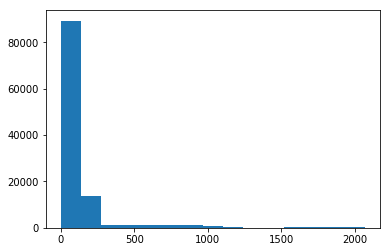

In [32]:
## plot the session lengh to check the distribution
bins, counts = Session_URL_df.select(col('SessionTime')).rdd.flatMap(lambda x: x).histogram(15)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [33]:
# if the given ip has a record in the following table
# the prediction for it's session length is the it's previous session's median
SessTime_byIP_df = Session_URL_df.groupBy("IP").agg(
    expr('percentile_approx(SessionTime, 0.5)').alias('MedianTime_byIP'))
SessTime_byIP_df.show()

+-------------+---------------+
|           IP|MedianTime_byIP|
+-------------+---------------+
| 1.186.101.79|           1118|
|1.186.103.240|             11|
| 1.186.103.78|              9|
|1.186.108.213|            113|
|1.186.108.230|             19|
|1.186.108.242|              3|
| 1.186.108.28|              6|
| 1.186.108.29|              5|
| 1.186.108.79|              0|
|1.186.111.224|            122|
| 1.186.112.12|            201|
| 1.186.112.52|             10|
|1.186.114.135|            109|
| 1.186.114.45|             15|
|1.186.117.150|              0|
| 1.186.128.57|             50|
|1.186.129.213|            116|
|1.186.135.123|             68|
|1.186.135.254|             55|
|1.186.138.134|              2|
+-------------+---------------+
only showing top 20 rows



In [34]:
# if the given ip has no record in the table
# the prediction for it's session length is the overall session's average
SessTime_default_df = Session_URL_df.agg(expr('percentile_approx(SessionTime, 0.5)').alias('MedianTime'))
SessTime_default_df.show()

+----------+
|MedianTime|
+----------+
|        19|
+----------+



### Predict the number of unique URL visits by a given IP
Same as the question above. As there's no other information available, we can only use IP, then we can use the mean/mode for each IP as the best guess. And use the mean/mode for all user as the best guess for IP showed first time.

(array([  1.05919000e+05,   1.20000000e+01,   9.00000000e+00,
          2.10000000e+01,   8.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   2.39275000e+02,   4.77550000e+02,
          7.15825000e+02,   9.54100000e+02,   1.19237500e+03,
          1.43065000e+03,   1.66892500e+03

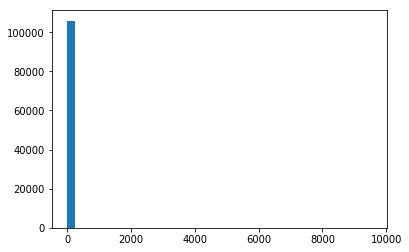

In [36]:
## plot the session lengh to check the distribution
bins, counts = Session_URL_df.select(col('Unique_URL_cnt')).rdd.flatMap(lambda x: x).histogram(40)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [37]:
# if the given ip has a record in the following table
# the prediction for it's session length is the it's previous session's average
URLcnt_byIP_df = Session_URL_df.groupBy("IP").agg(expr('percentile_approx(Unique_URL_cnt, 0.5)').alias('MedianURLcnt_byIP'))
URLcnt_byIP_df.show()

+-------------+-----------------+
|           IP|MedianURLcnt_byIP|
+-------------+-----------------+
| 1.186.101.79|               12|
|1.186.103.240|                5|
| 1.186.103.78|                4|
|1.186.108.213|                2|
|1.186.108.230|                5|
|1.186.108.242|                3|
| 1.186.108.28|               80|
| 1.186.108.29|                3|
| 1.186.108.79|                3|
|1.186.111.224|                9|
| 1.186.112.12|                3|
| 1.186.112.52|               16|
|1.186.114.135|                2|
| 1.186.114.45|                6|
|1.186.117.150|                1|
| 1.186.128.57|                8|
|1.186.129.213|                6|
|1.186.135.123|               11|
|1.186.135.254|                5|
|1.186.138.134|                2|
+-------------+-----------------+
only showing top 20 rows



In [38]:
URLcnt_default_df = Session_URL_df.agg(expr('percentile_approx(Unique_URL_cnt, 0.5)').alias('MedianURLcnt'))
URLcnt_default_df.show()

+------------+
|MedianURLcnt|
+------------+
|           3|
+------------+



## Other possible information for the later two problems
* There's browser verion information in the data, but didn't figure out why each records have multiple. If we can identify the browser version, we can use browser brand and version information in the prediction
* If there's patten in the URL that can fall into categories like 'home page' and 'item page'. This information can also be used for prediction